## Resnet 18

In [1]:
import numpy as np
import os
import torch
from torch.utils import data
from torch.utils.data import Dataset
from torch import nn

In [2]:
from DataAndModel import read_data, npdata_3, resnet_block18, transfrom

In [3]:
train_img,train_label = read_data(
    './data/data/img_train.npy','./data/data/label_train.npy', transfrom(transpose=(0,3,1,2)))
test_img,test_label = read_data(
    './data/data/img_test.npy','./data/data/label_test.npy', transfrom(transpose=(0,3,1,2)))
train_seq,train_label = read_data(
    './data/data/energy_train.npy','./data/data/label_train.npy', transfrom(reshape=(1,-1)))
test_seq,test_label = read_data(
    './data/data/energy_test.npy','./data/data/label_test.npy', transfrom(reshape=(1,-1)))

train_data = npdata_3(train_seq, train_img, train_label)
test_data = npdata_3(test_seq, test_img, test_label)


In [4]:
batch_size = 64
train_iter = data.DataLoader(train_data, batch_size,shuffle=True, num_workers=0)
test_iter = data.DataLoader(test_data, batch_size, num_workers=0)


# RESNET 18

In [5]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
                   
b2 = nn.Sequential(*resnet_block18(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block18(64, 128, 2))
b4 = nn.Sequential(*resnet_block18(128, 256, 2))
b5 = nn.Sequential(*resnet_block18(256, 512, 2))

In [6]:
resnet_18 = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512,256))
RESNET_18 = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 256))

In [7]:
X = torch.rand(size=(1, 3, 96, 96))
for layer in RESNET_18:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 48, 48])
Sequential output shape:	 torch.Size([1, 64, 48, 48])
Sequential output shape:	 torch.Size([1, 128, 24, 24])
Sequential output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 512, 6, 6])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 256])


# SPP

In [8]:
from DataAndModel import read_data, transfrom, spatial_pyramid_pooling

In [9]:
def cnn_1d_block(conv_arch):
    block = []
    for input_num, output_num, kernel, stride, padding in conv_arch:
        block.append(nn.Conv1d(input_num, output_num, kernel_size=kernel, stride=stride, padding=padding))
    return block


In [10]:
conv_arch = [
    [  1, 128, 4, 1, 2],
    [128, 128, 3, 2, 1],
    [128, 256, 2, 1, 1],
    [256, 256, 2, 1, 1],
    [256, 512, 2, 1, 1]
]
pool_size = [1, 2, 3]

In [11]:
SPP_net = nn.Sequential(
    *cnn_1d_block(conv_arch), 
    spatial_pyramid_pooling(pool_size),
    nn.Linear(3072, 512), nn.ReLU(),
    nn.Linear(512, 256)
    )

In [12]:
X = torch.rand(size=(1, 1, 127))
for layer in SPP_net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv1d output shape:	 torch.Size([1, 128, 128])
Conv1d output shape:	 torch.Size([1, 128, 64])
Conv1d output shape:	 torch.Size([1, 256, 65])
Conv1d output shape:	 torch.Size([1, 256, 66])
Conv1d output shape:	 torch.Size([1, 512, 67])
spatial_pyramid_pooling output shape:	 torch.Size([1, 3072])
Linear output shape:	 torch.Size([1, 512])
ReLU output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 256])


# FUSION

In [13]:
class Fusion(nn.Module):
    def __init__(self, model1, model2, method='cat') -> None:
        super().__init__()
        self.method = {'cat':1, 'max':2 ,'sum':3}[method]
        self.module1 = model1
        self.module2 = model2
        if self.method == 1:
            self.FC = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 5))
        else:
            self.FC = nn.Sequential(nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 5))
    def forward(self, x_1, x_2):
        X1 = self.module1(x_1)
        X2 = self.module2(x_2)
        if self.method ==1:
            X3 = torch.cat((X1,X2), 1)
        elif self.method ==2:
            X3 = torch.add(X1,X2)
        else:
            X3 = torch.max(X1,X2)
        X3 = X3.view(X3.size(0), -1)
        X4 = self.FC(X3)
        return X4 




In [14]:
class Fusion(nn.Module):
    def __init__(self, model1, model2, method='cat', r=4, record=False) -> None:
        super().__init__()
        self.method = {'cat':1, 'max':2 ,'sum':3}[method]
        self.module1 = model1
        self.module2 = model2
        if self.method == 1:
            self.FC = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 5))
        else:
            self.FC = nn.Sequential(nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 5))

        
        self.FAFS = nn.Sequential(nn.Linear(512, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 2),
                                  nn.Sigmoid(),
                                  nn.Softmax(dim=1))
        self.out = nn.Linear(256, 5)

    def forward(self, x_1, x_2):
        X1 = self.module1(x_1)
        X2 = self.module2(x_2)
        if self.method ==1:
            X3 = torch.cat((X1,X2), 1)
        elif self.method ==2:
            X3 = torch.add(X1,X2)
        else:
            X3 = torch.max(X1,X2)


        feature_weight = self.FAFS(torch.cat([X1, X2],1))
        fuse_feature = X1 * feature_weight[:, 0].unsqueeze(1) + X2 * feature_weight[:, 1].unsqueeze(1)
        
        out = self.out(fuse_feature)

        # X3 = X3.view(X3.size(0), -1)
        # X4 = self.FC(X3)
        return out,feature_weight
        # return  

In [15]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
m(input)[1,:],m(input)[1]

(tensor([0.5975, 0.2051, 0.1974]), tensor([0.5975, 0.2051, 0.1974]))

In [16]:
net_cat = Fusion(SPP_net, resnet_18)
net_max = Fusion(SPP_net, resnet_18, 'max')
net_sum = Fusion(SPP_net, resnet_18, 'sum' )

loss 0.007, train acc 0.999, test acc 0.930
514.1 examples/sec on cuda:0


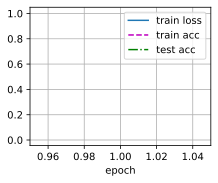

In [21]:
import TrainAndDraw2 as T
lr, num_epochs = 0.0001, 1
T.train_Fusion_2(net_cat, train_iter, test_iter, num_epochs, lr, T.try_gpu(), 
    'SPP_resnet18_fusion_cat',isini=1, isrecord=True)